# Exploring Point of Interests with Dask and Pandas
* Based on Jake Vanderplas and his excellent blog.

Recently we've been looking at the PyData ecosystem, and there are many interesting tools such as BColz and Biggus/. 
Dask is a very versatile tool that allows out-of-core dataframes without learning a whole host of other techniques. Under the hood, Dask simply uses standard Python, NumPy, and Pandas commands on each chunk, and transparently executes operations and aggregates results so that you can work with datasets that are larger than your machine's memory.

In this notebook, I'll take a look at how dask can be useful when looking at a large dataset: the full extracted points of interest from OpenStreetMap. We will use Dask to manipulate and explore the data, and also see the use of matplotlib's Basemap toolkit to visualize the results on a map.

The data points that will be drawn are pub locations extracted from OpenStreetMap and provided by osm-x-tractor.
When you download and extract the Points Of Interest (POI) dataset as a CSV file it has a file size of about 800 MB and more than 9 million entries for different types of locations. To filter out only the locations tagged as pubs you can use csvgrep, which is part of the csvkit toolkit.
csvgrep -c amenity -m pub POIWorld.csv > POIWorld-pub.csv

The resulting CSV file is much smaller with a size of 7.7 MB and contains a little more than 120,000 entries for pub locations all over the world. Since the coverage varies across countries and regions, I chose to limit the map to Britain and Ireland where POI coverage seems quite comprehensive and there are a lot of pubs. Who could have thought?
Next we load the required libraries and define a function that checks whether a given location tuple is within the given bounding box.
https://jakevdp.github.io/blog/2015/08/14/out-of-core-dataframes-in-python/


In [1]:
import dask as dask
dask.set_options(get=dask.async.get_sync)
nrows = sum(1 for _ in open('POIWorld.csv'))
nrows

9140114

In [2]:

import numpy as np

# create an array of normally-distributed random numbers
a = np.random.randn(1000)

# multiply this array by a factor
b = a * 4

# find the minimum value
b_min = b.min()
print(b_min)


-15.6321023287


We see here that dask stores the array as a dask array. 

In [3]:
import dask.array as da

# create a dask array from the above array
a2 = da.from_array(a, chunks=200)

# multiply this array by a factor
b2 = a2 * 4

# find the minimum value
b2_min = b2.min()
print(b2_min)

dask.array<p_reduc..., shape=(), dtype=float64, chunksize=()>


With Dask we can look into the inner workings of the dask graph

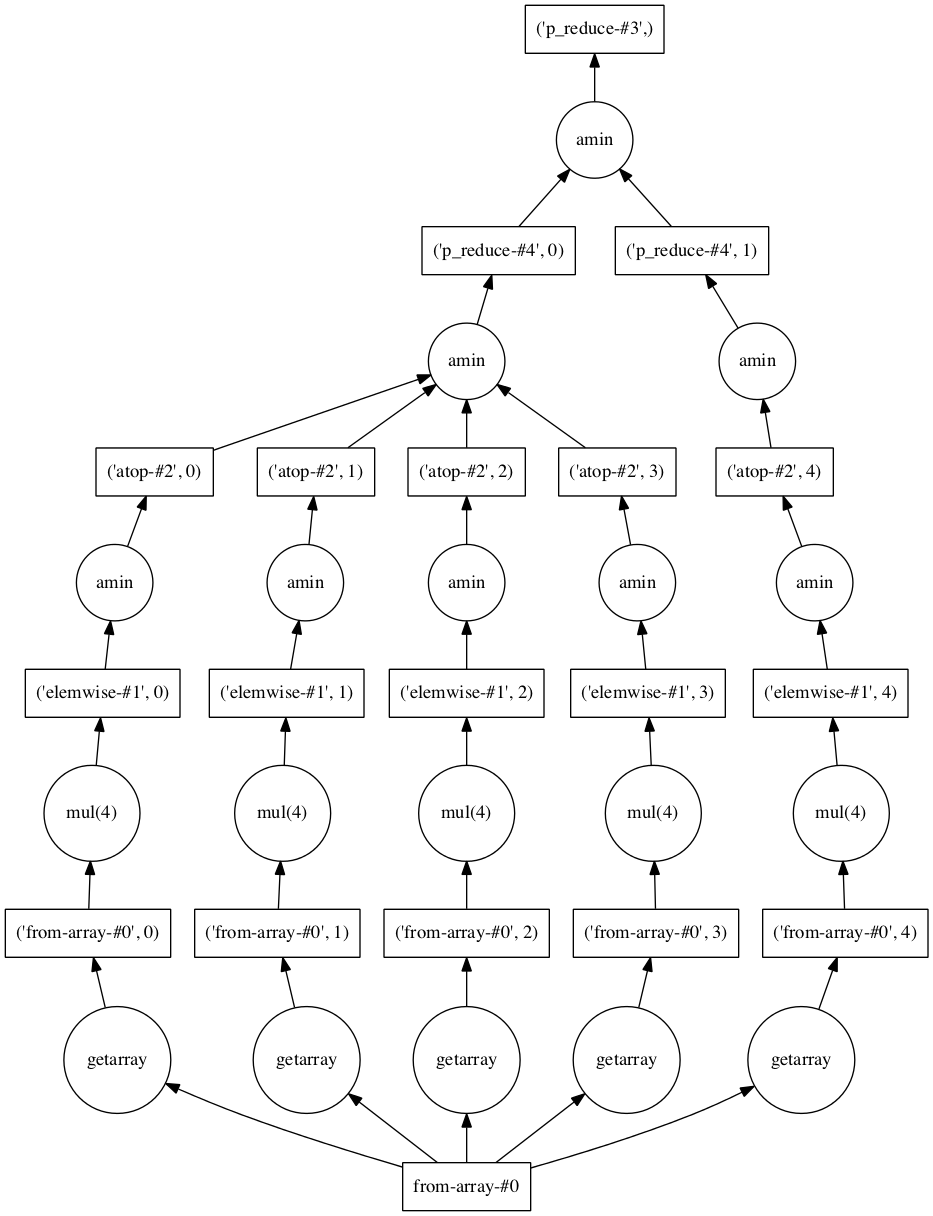

In [4]:
from dask.dot import dot_graph
dot_graph(b2_min.dask)

In [5]:
import pandas as pd
data = pd.read_csv('POIWorld.csv', nrows=3000000)
data.columns
data.amenity.value_counts()

/Users/peadarcoyle/anaconda/envs/pymc3_examples/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


place_of_worship                          248985
school                                    199875
bench                                     132532
restaurant                                120449
grave_yard                                113132
parking                                   111135
post_box                                   93335
fuel                                       86591
recycling                                  51791
bank                                       48477
fast_food                                  46517
pub                                        44977
telephone                                  44622
cafe                                       43699
post_office                                41622
pharmacy                                   41478
hospital                                   36130
bicycle_parking                            27100
fire_station                               26170
toilets                                    23948
atm                 

In [6]:
from dask import dataframe as dd
columns = ["name", "amenity", "Longitude", "Latitude"]
data = dd.read_csv('POIWorld.csv', usecols=columns)
data

dd.DataFrame<read-csv-POIWorld.csv-9d896e383f01e2c8463b17b3db2fe854, divisions=(None, None, None, ..., None, None)>

In [7]:
with_name = data[data.name.notnull()]


In [8]:
with_amenity = data[data.amenity.notnull()]

I want to work out how many schools there are in this database and plot them on a Graph

In [9]:
is_school = with_amenity.amenity.str.contains('[Ss]chool')
school = with_amenity[is_school]


In [11]:
dd.compute(school.amenity.count())

(342025,)

We have about 342 thousands Schools in this database.
Now we want to plot them just by a scatter graph on the UK and Ireland

In [12]:
lon, lat = dd.compute(school.Longitude, school.Latitude)
%matplotlib inline

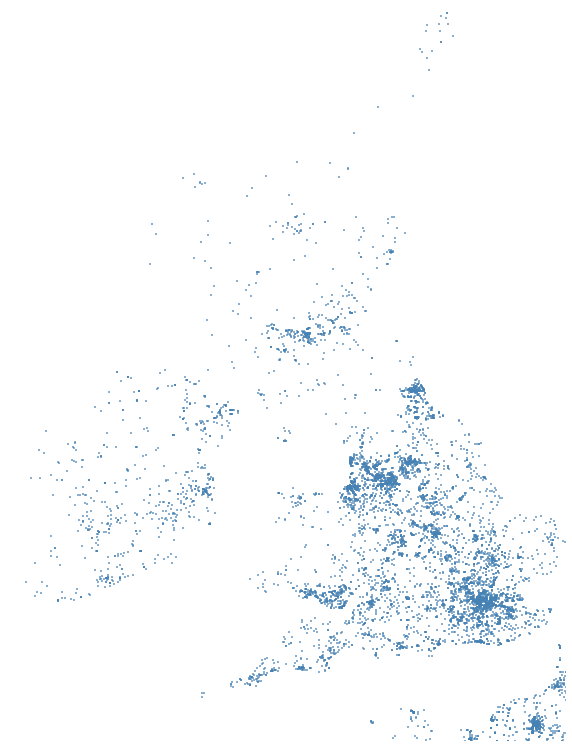

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
fig, ax = plt.subplots(figsize=(10, 15))
m = Basemap(projection='mill',
            lon_0=-5.23636, lat_0=53.866772,
            llcrnrlon=-10.65073, llcrnrlat=49.16209,
            urcrnrlon=1.76334, urcrnrlat=60.860699)
m.drawmapboundary(fill_color='#ffffff', linewidth=.0)
x, y = m(lon.values, lat.values)
m.scatter(x, y, s=1, marker=',', color="steelblue", alpha=0.6);